# CFD Modeling Process

Let's start by talking about what a CFD is? A Contract For Difference(CFD) is essentially a financial derivative, which means that its value depends on the value of a subjacent asset, for the purpose of this exercise, the subjacent asset will be a stock. 

Now the price of a CFD contract its determined by the difference of the current, and time of contract value of the subjacent asset. In a CFD negotiation there are two parts, buyer and seller, the buyer will pay to the seller the difference between the current value of an asset and its value at contract time, if the difference is negative the seller will pay the buyer.

This leads us to part of interest for this project, we want to know in advance which position will make money i.e. if the asset value will be larger than the future value or less for we to take the seller or buyer position, also would be benefitial to know what are going to be the extreme values of the asset to know the max liquidation risk and also the moment when the position should be close for maximum profit.

## Necesary Steps:

The notebook is going to be mainly divided in this steps for the modeling process.

1. Build features and objective variables within the data.
2. Build ML pipeline and model selection.
3. Additional Features.
4. Model optimization.
5. Save Model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time
import pickle

from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

## 1. Build Features and Objective Variables.

As stated in the intro we are interested in three variables, a classification to know whether the value of an `asset will rise or fall`, the `maximum value` the asset will take and the `minimum value` it will take. All of this depends of the time window we consider, so it is necesary to make that definition, for now we are going to stick with a `3 month` window.

We are going to define this process for one stock and then extend it to the rest of the stocks.

In [27]:
engine = create_engine('sqlite:///'+'stock_price.db')

df_d = pd.read_sql_table('FCEL_daily', engine)
df_w = pd.read_sql_table('FCEL_weekly', engine)
df_m = pd.read_sql_table('FCEL_monthly', engine)

Recaping on the data we saved from our API request the following structure for each frequency

In [28]:
df_d.head()

,index,open,high,low,close,adjusted close,volume,year,month,week
0,2021-10-18,7.690,8.93,7.670,8.74,8.74,158157913,2021,10,42
1,2021-10-15,7.260,7.85,7.130,7.39,7.39,46304186,2021,10,41
2,2021-10-14,7.380,7.44,6.870,7.22,7.22,39061771,2021,10,41
3,2021-10-13,7.200,7.31,6.930,7.25,7.25,29360583,2021,10,41
4,2021-10-12,6.745,7.04,6.705,6.92,6.92,18894619,2021,10,41


In [29]:
df_d.dtypes

index             datetime64[ns]
open                     float64
high                     float64
low                      float64
close                    float64
adjusted close           float64
volume                     int64
year                       int64
month                      int64
week                       int64
dtype: object

First we have to check which data frequency has the oldest data

In [30]:
df_d['index'] = pd.to_datetime(df_d['index'])
df_w['index'] = pd.to_datetime(df_w['index'])
df_m['index'] = pd.to_datetime(df_m['index'])

In [31]:
df_d['index'].min(), df_w['index'].min(), df_m['index'].min()

(Timestamp('1999-11-01 00:00:00'),
 Timestamp('1999-11-12 00:00:00'),
 Timestamp('1999-12-31 00:00:00'))

In [32]:
df_m.shape

(263, 10)

We can see that the full outputsize daily series has the most data, although the others are almost as complete as well and won't present difficulties in the modeling.

For features we are going to start with summarized data for all the six fields by periodicity with 100 data points for daily, 100 data points for weekly and 60 data points for monthly, this should help with all short, mid and long term trends and variances in the asset value and balance the contain information.

The process for achieving those features should be something along this

In [35]:
val_cols = ['open',
            'high',
            'low',
            'close',
            'adjusted close',
            'volume']


for col in val_cols:
    # initialize summarized variables
    df_m['mean_'+col] = -999
    df_w['mean_'+col] = -999
    df_d['mean_'+col] = -999
    
    # scan the dataframe backwards in time
    for i in range(df_d.shape[0]-100):
        # assign the mean of the last n observations to the relative entry
        df_d.loc[i, 'mean_'+col] = df_d.loc[i:i+100, col].mean()
    
    # scan the dataframe backwards in time
    for i in range(df_w.shape[0]-100):
        # assign the mean of the last n observations to the relative entry
        df_w.loc[i, 'mean_'+col] = df_w.loc[i:i+100, col].mean()
    
    # scan the dataframe backwards in time
    for i in range(df_m.shape[0]-60):
        # assign the mean of the last n observations to the relative entry
        df_m.loc[i, 'mean_'+col] = df_m.loc[i:i+60, col].mean()
        

In [36]:
df_d.head()

,index,open,high,low,close,adjusted close,volume,year,month,week,mean_open,mean_high,mean_low,mean_close,mean_adjusted close,mean_volume
0,2021-10-18,7.690,8.93,7.670,8.74,8.74,158157913,2021,10,42,7.436618,7.716428,7.176482,7.419604,7.419604,2.369202e+07
1,2021-10-15,7.260,7.85,7.130,7.39,7.39,46304186,2021,10,41,7.443450,7.713952,7.182918,7.416436,7.416436,2.226256e+07
2,2021-10-14,7.380,7.44,6.870,7.22,7.22,39061771,2021,10,41,7.461063,7.725725,7.193855,7.427426,7.427426,2.201812e+07
3,2021-10-13,7.200,7.31,6.930,7.25,7.25,29360583,2021,10,41,7.472210,7.741467,7.208806,7.444158,7.444158,2.186002e+07
4,2021-10-12,6.745,7.04,6.705,6.92,6.92,18894619,2021,10,41,7.487160,7.756110,7.220390,7.456337,7.456337,2.173841e+07


That was for the summarized features, now on the daily dataframe we are going to define the objective variables.

In [37]:
df_d.columns[df_d.columns.str.contains('mean')]

Index(['mean_open', 'mean_high', 'mean_low', 'mean_close',
       'mean_adjusted close', 'mean_volume'],
      dtype='object')

In [38]:
obj_cols = ['obj_rise',
            'obj_max',
            'obj_min']

# initialize columns
df_d['obj_rise'] = -999
df_d['obj_max'] = -999
df_d['obj_min'] = -999

# scan the dataframe backwards in time
for i in range(df_d.shape[0]):
    
    # define start date as the current index value for the row
    start_date = df_d.iloc[i,0]
    # define end date as the start date plus 3 months
    end_date = start_date + pd.DateOffset(months=3)
    
    # check if there are entries at or after the end date
    if df_d['index'].max() < end_date:
        continue
    
    # get data from start to end date
    df_3_month = df_d[(df_d['index']> start_date) & (df_d['index']<= end_date)]
    
    # assing realization of the minimun and maximun values
    df_d.loc[i, 'obj_max'] = df_3_month['close'].max()
    df_d.loc[i, 'obj_min'] = df_3_month['close'].min()
    
    # identify wheter the stock value increase compared to starting price
    if df_3_month.tail(1)['close'].values[0] > df_d.loc[i, 'close']:
        df_d.loc[i, 'obj_rise'] = 1
    else:
        df_d.loc[i, 'obj_rise'] = 0

In [39]:
df_d.tail()

,index,open,high,low,close,adjusted close,volume,year,month,week,mean_open,mean_high,mean_low,mean_close,mean_adjusted close,mean_volume,obj_rise,obj_max,obj_min
5522,1999-11-05,29.87,30.87,29.87,30.50,732.00,20200,1999,11,44,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94
5523,1999-11-04,27.12,29.25,27.12,29.12,698.88,15600,1999,11,44,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94
5524,1999-11-03,26.37,26.62,26.25,26.50,636.00,5067,1999,11,44,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94
5525,1999-11-02,26.00,26.50,26.00,26.25,630.00,4067,1999,11,44,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94
5526,1999-11-01,25.50,26.12,25.25,25.87,620.88,14600,1999,11,44,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94


In [41]:
df_d.obj_rise.value_counts()

 0      2990
 1      2472
-999      65
Name: obj_rise, dtype: int64

Seems as pretty decently balanced data.

Now that all summarized data was builded for all frequencies/periodicities we merge it all together.

In [43]:
df_features = df_w.merge(df_m,
                         'left',
                         left_on = ['year', 'month'],
                         right_on = ['year', 'month'],
                         suffixes = ('_weekly', '_monthly'))

df_features = df_d.merge(df_features,
                         'left',
                         left_on = ['year', 'week'],
                         right_on = ['year', 'week_weekly'],
                         suffixes = ('','_weekly'))
df_features.head()

,index,open,high,low,close,adjusted close,volume,year,month,week,...,close_monthly,adjusted close_monthly,volume_monthly,week_monthly,mean_open_monthly,mean_high_monthly,mean_low_monthly,mean_close_monthly,mean_adjusted close_monthly,mean_volume_monthly
0,2021-10-18,7.690,8.93,7.670,8.74,8.74,158157913,2021,10,42,...,8.74,8.74,408741564.0,42.0,3.272407,4.342423,2.408536,3.265228,10.984198,2.780146e+08
1,2021-10-15,7.260,7.85,7.130,7.39,7.39,46304186,2021,10,41,...,8.74,8.74,408741564.0,42.0,3.272407,4.342423,2.408536,3.265228,10.984198,2.780146e+08
2,2021-10-14,7.380,7.44,6.870,7.22,7.22,39061771,2021,10,41,...,8.74,8.74,408741564.0,42.0,3.272407,4.342423,2.408536,3.265228,10.984198,2.780146e+08
3,2021-10-13,7.200,7.31,6.930,7.25,7.25,29360583,2021,10,41,...,8.74,8.74,408741564.0,42.0,3.272407,4.342423,2.408536,3.265228,10.984198,2.780146e+08
4,2021-10-12,6.745,7.04,6.705,6.92,6.92,18894619,2021,10,41,...,8.74,8.74,408741564.0,42.0,3.272407,4.342423,2.408536,3.265228,10.984198,2.780146e+08


We are going to have some missing values as for the oldest data points there is not enough relative data points in the past and for the most recent data points there is still not a realization of the objective variables.

In [50]:
df_features = df_features[df_features.columns[(df_features.columns.str.contains('mean')) | (df_features.columns.str.contains('obj'))]]
df_features.isnull().mean()

mean_open                      0.000000
mean_high                      0.000000
mean_low                       0.000000
mean_close                     0.000000
mean_adjusted close            0.000000
mean_volume                    0.000000
obj_rise                       0.000000
obj_max                        0.000000
obj_min                        0.000000
mean_open_weekly               0.000905
mean_high_weekly               0.000905
mean_low_weekly                0.000905
mean_close_weekly              0.000905
mean_adjusted close_weekly     0.000905
mean_volume_weekly             0.000905
mean_open_monthly              0.003438
mean_high_monthly              0.003438
mean_low_monthly               0.003438
mean_close_monthly             0.003438
mean_adjusted close_monthly    0.003438
mean_volume_monthly            0.003438
dtype: float64

In [51]:
df_features.tail()

,mean_open,mean_high,mean_low,mean_close,mean_adjusted close,mean_volume,obj_rise,obj_max,obj_min,mean_open_weekly,...,mean_low_weekly,mean_close_weekly,mean_adjusted close_weekly,mean_volume_weekly,mean_open_monthly,mean_high_monthly,mean_low_monthly,mean_close_monthly,mean_adjusted close_monthly,mean_volume_monthly
5522,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5523,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5524,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5525,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5526,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,56.0,21.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is necesary to eliminate this entries where we don't have features to make predictions, as we are intersted in predicting with recent data and that will always have these summarized features and as for the entries with out objective values, for this stage we are discarding them as we can't tell yet if we are making good predictions or not.

In [52]:
decode_null = lambda x: x.replace(-999, np.nan)

In [53]:
df_features = df_features.apply(decode_null, axis = 1)

In [54]:
df_features.isnull().mean()

mean_open                      0.018093
mean_high                      0.018093
mean_low                       0.018093
mean_close                     0.018093
mean_adjusted close            0.018093
mean_volume                    0.018093
obj_rise                       0.011760
obj_max                        0.011760
obj_min                        0.011760
mean_open_weekly               0.087751
mean_high_weekly               0.087751
mean_low_weekly                0.087751
mean_close_weekly              0.087751
mean_adjusted close_weekly     0.087751
mean_volume_weekly             0.087751
mean_open_monthly              0.230686
mean_high_monthly              0.230686
mean_low_monthly               0.230686
mean_close_monthly             0.230686
mean_adjusted close_monthly    0.230686
mean_volume_monthly            0.230686
dtype: float64

In [58]:
df_features.dropna().shape

(4187, 21)

That would be pretty much all the process to get the features, so let's pack all this in some modules to make it reproducible.

In [2]:
class LoadStockFeatures(BaseEstimator, TransformerMixin):
    def load_freq_data(self, stock_symbol, freq):
        """
        Load stock_symbol data for the defined frequency.
        """
        engine = create_engine('sqlite:///'+'stock_price.db')
        df = pd.read_sql_table(stock_symbol + '_' + freq, engine)
        df['index'] = pd.to_datetime(df['index'])
        return df
    
    def build_summarized_features(self, df, n_points):
        """
        Get the mean of the last n_points for the value columns
        """
        
        val_cols = ['open',
                    'high',
                    'low',
                    'close',
                    'adjusted close',
                    'volume']
        
        # initialize the mean columns
        for col in val_cols:
            df['mean_'+col] = -999
            
            # scan the dataframe backwards in time
            for i in range(df.shape[0]-n_points):
                # assign the mean of the last n observations to the relative entry
                df.loc[i, 'mean_'+col] = df.loc[i:i+n_points, col].mean()
            
        return df
    
    def build_obj_vals(self, df, f_months):
        # initialize columns
        df['obj_rise'] = -999
        df['obj_max'] = -999
        df['obj_min'] = -999
        
        # scan the dataframe backwards in time
        for i in range(df.shape[0]):
            
            # assing start and end date
            start_date = df.iloc[i,0]
            end_date = start_date + pd.DateOffset(months=f_months)
            
            # check if there are entries at or after the end date
            if df['index'].max() < end_date:
                continue
            # get data from start to end date
            df_3_month = df[(df['index']> start_date) & (df['index']<= end_date)]
            
            # assing realization of the minimun and maximun values
            df.loc[i, 'obj_max'] = df_3_month['close'].max()
            df.loc[i, 'obj_min'] = df_3_month['close'].min()
            
            # identify wheter the stock value increase compared to starting price
            if df_3_month.tail(1)['close'].values[0] > df.loc[i, 'close']:
                df.loc[i, 'obj_rise'] = 1
            else:
                df.loc[i, 'obj_rise'] = 0
        
        return df
    
    def decode_nulls(self, df):
        """
        Replace initialized only values in the data with np.nan.
        """
        decode_null = lambda x: x.replace(-999, np.nan)
        df = df.apply(decode_null, axis = 1)
        return df
    
    def fit(self):
        return self
    
    def transform(self, stock_symbol, n_day = 100, n_week = 100, n_month = 60, f_months = 3):
        """
        Run complete feature and objetive values building process for stock_symbol.
        """
        df_d = self.load_freq_data(stock_symbol, 'daily')
        df_w = self.load_freq_data(stock_symbol, 'weekly')
        df_m = self.load_freq_data(stock_symbol, 'monthly')
        print('Loaded time series for the symbol...')
        
        df_d = self.build_summarized_features(df_d, n_day)
        df_w = self.build_summarized_features(df_w, n_week)
        df_m = self.build_summarized_features(df_m, n_month)
        print('Builded sumarized features for the symbol...')
        
        df_d = self.build_obj_vals(df_d, f_months)
        print('Builded objetive variables for the symbol...')
        
        df = df_w.merge(df_m,
                         'left',
                         left_on = ['year', 'month'],
                         right_on = ['year', 'month'],
                         suffixes = ('_weekly', '_monthly'))
        df = df_d.merge(df,
                        'left',
                        left_on = ['year', 'week'],
                        right_on = ['year', 'week_weekly'],
                        suffixes = ('','_weekly'))
        print('Merged all relevant data...')
        df = df[df.columns[(df.columns.str.contains('mean')) | (df.columns.str.contains('obj'))]]
        df = self.decode_nulls(df)
        print('Decoded null entries...')
        
        df = df.dropna()
        print('Dropped null entries...')
        print(' Succesfully loaded symbol features!')
        return df

In [3]:
import time
lsf = LoadStockFeatures()
start_time = time.time()
df = lsf.transform('AAPL', f_months = 1)
print("--- %s seconds ---" % (time.time() - start_time))

Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
--- 16.96144962310791 seconds ---


In [4]:
df.shape

(4232, 21)

All though the LoadStockFeatures class is created as a sklearn estimator object, is unlikely we are going to use it within a sklearn pipeline, because we can't feed this object train and testing sets separately, nevertheless this class will prove usefull in the future.

## 2. Build ML pipeline and model selection

To make tasks easier facing forward we are going to build an object that allows to run a full train, predict process on the same data for all of our objective variables.

In [5]:
class ClassifierRegressorCombo():
    """
    Combination of classifier and regressor object to predict over the same features.
    """
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    def __init__(self, df, clf = RandomForestClassifier(), reg = RandomForestRegressor(), clf_acc = 0, r2_max = 0, r2_min = 0):
        self.df = df
        self.clf = clf
        self.reg = reg
        self.clf_acc = clf_acc
        self.r2_max = r2_max
        self.r2_min = r2_min
    
    def set_df(self, df):
        self.df = df
    
    def fit(self):
        """
        Run fitting process for classifier and regressor objects.
        """
        X = self.df[self.df.columns[self.df.columns.str.contains('mean')]]
        clf_y = self.df['obj_rise']
        reg_y = self.df[['obj_max','obj_min']]
        self.clf.fit(X, clf_y)
        self.reg.fit(X, reg_y)
        
    def predict(self):
        """
        Run predict method for classifier and regressor objects.
        """
        X = self.df[self.df.columns[self.df.columns.str.contains('mean')]]
        clf_pred = self.clf.predict(X)
        reg_pred = self.reg.predict(X)
        return clf_pred, reg_pred
    
    def clf_report(self, clf_true, clf_pred):
        """
        Get metrics for the classifier.
        """
        print(classification_report(clf_true, clf_pred))
        self.clf_acc = accuracy_score(clf_true, clf_pred)
        
    def reg_report(self, reg_true, reg_pred):
        """
        Get metrics for the regressor.
        """
        print(" R2 for the maximum value regression: {}".format(r2_score(reg_true['obj_max'], reg_pred[:, 0])))
        self.r2_max = r2_score(reg_true['obj_max'], reg_pred[:, 0])
        print(" R2 for the minimun value regression: {}".format(r2_score(reg_true['obj_min'], reg_pred[:, 1])))     
        self.r2_min = r2_score(reg_true['obj_min'], reg_pred[:, 1])
    def full_test(self):
        """
        Train, predict and get metrics for the classifier and regressor.
        """
        df = self.df
        # split data into test and testing sets
        df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
        print("Splited train and test sets...")
        
        # use training data for fitting method
        self.set_df(df_train)
        self.fit()
        print("Trained models on train set...")
        
        # use testing data for predict method
        self.set_df(df_test)        
        clf_pred, reg_pred = self.predict()
        
        # display and store evaluation metrics
        print("Predicted on test set...")
        print("Classification Report: {}".format(self.clf.__class__.__name__))
        self.clf_report(df_test['obj_rise'], clf_pred)
        
        try:
            print("Regresion Report: {}".format(self.reg.estimator.__class__.__name__))
        except:
            print("Regresion Report: {}".format(self.reg.__class__.__name__))
            
        self.reg_report(df_test[['obj_max','obj_min']], reg_pred)
        return None

In [6]:
clf_reg = ClassifierRegressorCombo(df = df)
clf_reg.full_test()

Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.43      0.48      0.45       380
         1.0       0.54      0.49      0.52       467

    accuracy                           0.49       847
   macro avg       0.49      0.49      0.48       847
weighted avg       0.49      0.49      0.49       847

Regresion Report: RandomForestRegressor
 R2 for the maximum value regression: 0.993125866989895
 R2 for the minimun value regression: 0.9995979372678829


With our class for testing both model at the same time, we can go ahead and test for multiple models and evaluate their performances

### 2.1 Model Selection

In [4]:
# Models to evaluate
clfs = [RandomForestClassifier(), 
        AdaBoostClassifier(),
        BaggingClassifier(), 
        GradientBoostingClassifier(),
        MLPClassifier(),
        SVC()]

regs = [RandomForestRegressor(),
        MultiOutputRegressor(AdaBoostRegressor()),
        BaggingRegressor(),
        MultiOutputRegressor(GradientBoostingRegressor()),
        MultiOutputRegressor(MLPRegressor()),
        MultiOutputRegressor(SVR())]

In [7]:
#  initialize metrics dictionary
model_select_dict = {'symbol':[],
                     'classifier':[],
                     'classfication accuracy':[],
                     'regressor':[],
                     'r2 score for max value':[],
                     'r2 score for min value':[],
                     'time':[]}

symbols = ['FCEL', 'AAPL', 'BAC', 'M']

for symbol in symbols:
    
    # instantiate object for feature retrieving
    lsf = LoadStockFeatures()
    print('--------- MODELS FOR {}  ---------'.format(symbol))
    # get features
    df = lsf.transform(symbol)
    for clf, reg in zip(clfs, regs):
        start_time = time.time()
        
        # instantiate classifier and regressor combination object
        clf_reg = ClassifierRegressorCombo(df = df, clf = clf, reg = reg)
        
        # run train test evaluate process
        clf_reg.full_test()
        
        # append data to the metric dictionary
        model_select_dict['symbol'].append(symbol)
        model_select_dict['classifier'].append(clf_reg.clf.__class__.__name__)
        model_select_dict['classfication accuracy'].append(clf_reg.clf_acc)
        
        # check for regression estimators wrapped in multioutput object
        try:
            model_select_dict['regressor'].append(clf_reg.reg.estimator.__class__.__name__)
        except:
            model_select_dict['regressor'].append(clf_reg.reg.__class__.__name__)
        
        model_select_dict['r2 score for max value'].append(clf_reg.r2_max)
        model_select_dict['r2 score for min value'].append(clf_reg.r2_min)      
        
        model_select_dict['time'].append(time.time() - start_time)
        print('\n')

--------- MODELS FOR FCEL  ---------
Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.53      0.57      0.55       464
         1.0       0.41      0.36      0.38       374

    accuracy                           0.48       838
   macro avg       0.47      0.47      0.47       838
weighted avg       0.47      0.48      0.47       838

Regresion Report: RandomForestRegressor
 R2 for the maximum value regression: 0.999281719091518
 R2 for the minimun value regression: 0.9984708067489484


Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report

C:\Users\justC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Trained models on train set...
Predicted on test set...
Classification Report: MLPClassifier
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       464
         1.0       0.50      0.00      0.01       374

    accuracy                           0.55       838
   macro avg       0.53      0.50      0.36       838
weighted avg       0.53      0.55      0.40       838

Regresion Report: MLPRegressor
 R2 for the maximum value regression: -2210809.8537143483
 R2 for the minimun value regression: -11220050.29499832


Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: SVC
              precision    recall  f1-score   support

         0.0       0.56      0.93      0.70       464
         1.0       0.51      0.09      0.15       374

    accuracy                           0.55       838
   macro avg       0.53      0.51      0.43       838
weighted avg       0.54      0.55      0.46   

C:\Users\justC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained models on train set...
Predicted on test set...
Classification Report: SVC
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       417
         1.0       0.50      1.00      0.67       421

    accuracy                           0.50       838
   macro avg       0.25      0.50      0.33       838
weighted avg       0.25      0.50      0.34       838

Regresion Report: SVR
 R2 for the maximum value regression: 0.056359861786987486
 R2 for the minimun value regression: 0.0825840821540541


--------- MODELS FOR BAC  ---------


C:\Users\justC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48       420
         1.0       0.47      0.47      0.47       418

    accuracy                           0.47       838
   macro avg       0.47      0.47      0.47       838
weighted avg       0.47      0.47      0.47       838

Regresion Report: RandomForestRegressor
 R2 for the maximum value regression: 0.9999173993466514
 R2 for the minimun value regression: 0.9996863187742354


Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: AdaBoostClassifier
              p

C:\Users\justC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\justC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\justC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained models on train set...
Predicted on test set...
Classification Report: MLPClassifier
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       420
         1.0       0.00      0.00      0.00       418

    accuracy                           0.50       838
   macro avg       0.25      0.50      0.33       838
weighted avg       0.25      0.50      0.33       838

Regresion Report: MLPRegressor
 R2 for the maximum value regression: -232030323.6847187
 R2 for the minimun value regression: -80269925.68089539


Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: SVC
              precision    recall  f1-score   support

         0.0       0.52      0.26      0.35       420
         1.0       0.51      0.76      0.61       418

    accuracy                           0.51       838
   macro avg       0.52      0.51      0.48       838
weighted avg       0.52      0.51      0.48    

C:\Users\justC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Trained models on train set...
Predicted on test set...
Classification Report: MLPClassifier
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65       400
         1.0       0.00      0.00      0.00       438

    accuracy                           0.48       838
   macro avg       0.24      0.50      0.32       838
weighted avg       0.23      0.48      0.31       838

Regresion Report: MLPRegressor
 R2 for the maximum value regression: -398201.09050574264
 R2 for the minimun value regression: -387198.5949219124


Splited train and test sets...


C:\Users\justC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained models on train set...
Predicted on test set...
Classification Report: SVC
              precision    recall  f1-score   support

         0.0       0.47      0.63      0.54       400
         1.0       0.50      0.34      0.41       438

    accuracy                           0.48       838
   macro avg       0.49      0.49      0.47       838
weighted avg       0.49      0.48      0.47       838

Regresion Report: SVR
 R2 for the maximum value regression: 0.7240959179210604
 R2 for the minimun value regression: 0.684980262256143




In [8]:
model_select_df = pd.DataFrame(model_select_dict)
model_select_df.head()

,symbol,classifier,classfication accuracy,regressor,r2 score for max value,r2 score for min value,time
0,FCEL,RandomForestClassifier,0.478520,RandomForestRegressor,9.992817e-01,9.984708e-01,3.007023
1,FCEL,AdaBoostClassifier,0.546539,AdaBoostRegressor,9.412947e-01,9.433495e-01,1.038254
2,FCEL,BaggingClassifier,0.472554,BaggingRegressor,9.981927e-01,9.986618e-01,0.588603
3,FCEL,GradientBoostingClassifier,0.526253,GradientBoostingRegressor,9.935031e-01,9.931983e-01,2.949513
4,FCEL,MLPClassifier,0.553699,MLPRegressor,-2.210810e+06,-1.122005e+07,4.302970


In [9]:
model_select_df[model_select_df['r2 score for max value'] < 0]

,symbol,classifier,classfication accuracy,regressor,r2 score for max value,r2 score for min value,time
4,FCEL,MLPClassifier,0.553699,MLPRegressor,-2.210810e+06,-1.122005e+07,4.302970
10,AAPL,MLPClassifier,0.497613,MLPRegressor,-1.415780e+04,-5.113194e+04,3.868173
16,BAC,MLPClassifier,0.501193,MLPRegressor,-2.320303e+08,-8.026993e+07,5.899026
22,M,MLPClassifier,0.477327,MLPRegressor,-3.982011e+05,-3.871986e+05,4.309250


We can see that the number of points it's definitely not ideal for the MLPRegressor, so for now we are going to inpute this r2 scores with `0` strictly for visualization purposes.

In [10]:
model_select_df['r2 score for max value'] = np.where(model_select_df['r2 score for max value'] < 0,
                                                     0,
                                                     model_select_df['r2 score for max value'])
model_select_df['r2 score for min value'] = np.where(model_select_df['r2 score for min value'] < 0,
                                                     0,
                                                     model_select_df['r2 score for min value'])

### Performance of the Classifiers

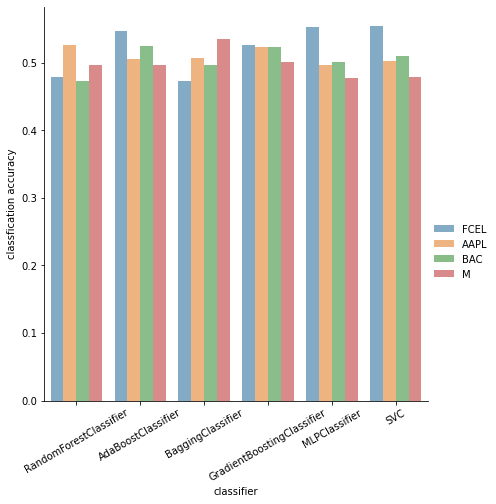

In [11]:
g = sns.catplot(data=model_select_df, 
                kind="bar", 
                x="classifier", 
                y="classfication accuracy", 
                hue="symbol", 
                alpha=.6,
                height=6);
g.legend.set_title("")
g.set_xticklabels(rotation=30)

### Performance of the Regressors

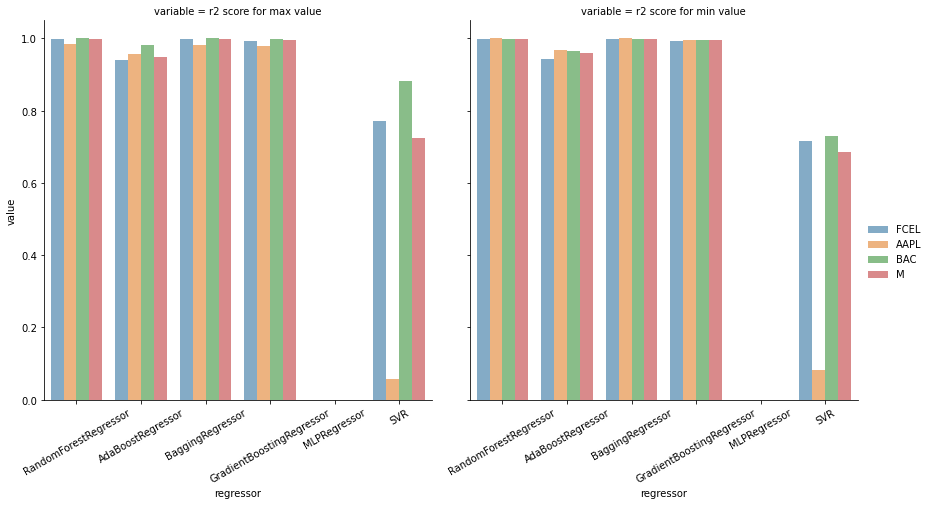

In [12]:
g = sns.catplot(data=pd.melt(model_select_df, id_vars=['symbol','regressor'], 
                             value_vars=['r2 score for max value', 'r2 score for min value']), 
                kind="bar", 
                x="regressor", 
                y="value",
                col = 'variable',
                hue="symbol", 
                alpha=.6,
                height=6);
g.legend.set_title("")
g.set_xticklabels(rotation=30)

### Time of excecution

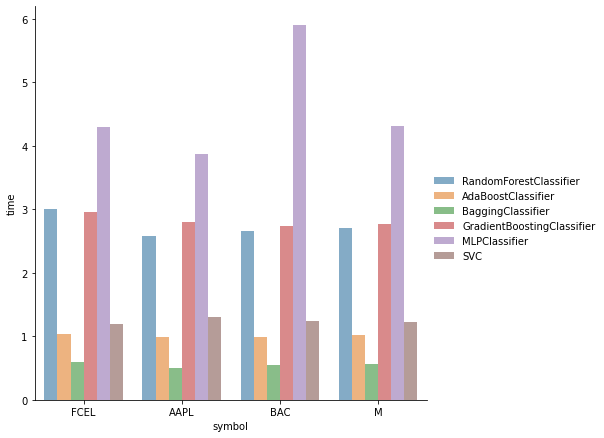

In [13]:
g = sns.catplot(data=model_select_df, 
                kind="bar", 
                x="symbol", 
                y="time", 
                hue="classifier", 
                alpha=.6,
                height=6);
g.legend.set_title("")

### Best Performing Estimator by Stock

In [14]:
for symbol in symbols:
    clf = list(model_select_df[model_select_df['symbol']==symbol]. \
               sort_values('classfication accuracy',
                           ascending = False)['classifier'])[0]
    reg = list(model_select_df[model_select_df['symbol']==symbol]. \
               sort_values('r2 score for max value',
                           ascending = False)['regressor'])[0]
    print("{} -- classifier: {}. regressor: {}".format(symbol, clf, reg))
    

FCEL -- classifier: SVC. regressor: RandomForestRegressor
AAPL -- classifier: RandomForestClassifier. regressor: RandomForestRegressor
BAC -- classifier: AdaBoostClassifier. regressor: RandomForestRegressor
M -- classifier: BaggingClassifier. regressor: RandomForestRegressor


### Best Estimators On Average

In [15]:
model_select_df.groupby(by = 'classifier').mean()['classfication accuracy'].sort_values(ascending = False)

classifier
GradientBoostingClassifier    0.518795
AdaBoostClassifier            0.518496
SVC                           0.511933
MLPClassifier                 0.507458
BaggingClassifier             0.503282
RandomForestClassifier        0.493735
Name: classfication accuracy, dtype: float64

In [16]:
aux_model = model_select_df.groupby(by = 'regressor').mean()[['r2 score for max value', 'r2 score for min value']]
aux_model['avg r2 score'] = aux_model.apply(np.mean, axis = 1)
aux_model.sort_values(by = 'avg r2 score', ascending = False)

,r2 score for max value,r2 score for min value,avg r2 score
regressor,,,
RandomForestRegressor,0.995902,0.999373,0.997638
BaggingRegressor,0.995079,0.999353,0.997216
GradientBoostingRegressor,0.991628,0.995449,0.993538
AdaBoostRegressor,0.957591,0.958885,0.958238
SVR,0.608487,0.553568,0.581027
MLPRegressor,0.000000,0.000000,0.000000


For simplicity of the optimization process, only one parameter dictionary for classification and regressor estimator, we are going to pick the same model type across all stocks. Also the there is not to much relative difference between the best on average accross all stock vs the best performing per stock.

So we are going to use the following estimators

`GradientBoostingClassifier` and `RandomForestRegressor`

## 3. Additional Features.

Looking to further improve the classification results we are goint to include some extra features, as the original features are not being enough.

We are going to extend the LoadStockFeatures class to include two more features.

### 3.1 Average of the last 100 daily returns of the stock.

$$ \mu_t: \text{return for the day }t \qquad S_t: \text{Stock value at day } t$$

$$ \mu_0:= 0  \qquad \mu_t :=ln\left(\frac{S_t}{S_{t-1}}\right) $$

$$ \hat\mu_n(t) = \frac{\sum_{i = 1}^n \mu_{t-i}}{n} $$

This returns are the main modeling tool in the [modern portafolio theory.](https://www.jstor.org/stable/2975974)
### 3.2 Percentage of the last 100 days that the stock is below the current value.

$$ P_{n}(t): \text{percentage of the last } n \text{ days at time }t \text{ that the stock is below the current value } S_t$$
$$ P_{n}(t) = \frac{\sum_{i = 1}^{n}I_{\left(-\infty, S_t\right)}\left(S_{t-i}\right)}{n} $$

As the classification can be interpreted as predicting a bernoulli random variable, this feature would correspond to the maximum likelihood estimator for the mean of that variable, given the sample of the last 100 days.

### 3.3 Polynomial Features.

This type of transformations would allows to include interactions within features and maybe allow the models to grasp better the relevant patterns.

For detail info [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=poly#sklearn.preprocessing.PolynomialFeatures)

We are going to extent our LoadStockFeatures class with the first to additional features

In [9]:
class LoadStockFeaturesExtended(LoadStockFeatures):
    def build_extended_features(self, df, n_points):
        """
        Get mean return and number of days below actual price for n_points days back.
        """
        
        # initialize columns
        df['mean_return'] = -999
        df['mean_days_below'] = -999
        
        # scan dataframe backwards in time
        for i in range(df.shape[0]-n_points):
            
            # get the mean return of the last n_points days - only n_points-1 values
            df.loc[i, 'mean_return'] = np.mean(np.log(np.divide(np.array(df.loc[i:i+n_points-1, 'close']), 
                                                                np.array(df.loc[i+1:i+n_points, 'close']))))
            # get the mean of the number of days were stock value below current value
            df.loc[i, 'mean_days_below'] = np.mean(np.array(df.loc[i:i+n_points-1, 'close'])<df.loc[i, 'close'])
            
        return df
    
    def transform(self, stock_symbol, n_day = 100, n_week = 100, n_month = 60, f_months = 3):
        """
        Run complete features extended and objetive values building process for stock_symbol.
        """
        df_d = self.load_freq_data(stock_symbol, 'daily')
        print(df_d.shape)
        df_w = self.load_freq_data(stock_symbol, 'weekly')
        df_m = self.load_freq_data(stock_symbol, 'monthly')
        print('Loaded time series for the symbol...')
        
        df_d = self.build_summarized_features(df_d, n_day)
        df_d = self.build_extended_features(df_d, n_day)
        df_w = self.build_summarized_features(df_w, n_week)
        df_m = self.build_summarized_features(df_m, n_month)
        print('Builded sumarized features for the symbol...')
        
        df_d = self.build_obj_vals(df_d, f_months)
        print('Builded objetive variables for the symbol...')
        
        df = df_w.merge(df_m,
                         'left',
                         left_on = ['year', 'month'],
                         right_on = ['year', 'month'],
                         suffixes = ('_weekly', '_monthly'))
        df = df_d.merge(df,
                        'left',
                        left_on = ['year', 'week'],
                        right_on = ['year', 'week_weekly'],
                        suffixes = ('','_weekly'))
        print('Merged all relevant data...')
        df = df[df.columns[(df.columns.str.contains('mean')) | (df.columns.str.contains('obj'))]]
        df = self.decode_nulls(df)
        print('Decoded null entries...')
        
        df = df.dropna()
        print('Dropped null entries...')
        print(' Succesfully loaded symbol features!')
        return df

In [10]:
lsef = LoadStockFeaturesExtended()
start_time = time.time()
df = lsef.transform('AAPL')
print(time.time()-start_time)

(5529, 10)
Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
19.991477012634277


In [11]:
df.shape

(4189, 23)

As the regression part is already performing really well, we are not going to add PolynomialFeatures to that part of the pipeline for the sake of simplicity.

Lets inspect how the chosen models perform with each feature set.

In [12]:
lsef = LoadStockFeaturesExtended()
lsf = LoadStockFeatures()
for symbol in ['AAPL', 'FCEL', 'BAC', 'M']:
    print('\n ------------------------------------ {} ------------------------------------ \n'.format(symbol))
    # get data features for the symbol
    df = lsf.transform(symbol)
    
    clf_reg = ClassifierRegressorCombo(df = df, clf = GradientBoostingClassifier(), reg = RandomForestRegressor())
    print('\n----- RESULTS FOR INITIAL FEATURES -----\n')
    
    # run train test evaluate process
    clf_reg.full_test()
    
    # get extended features for the symbol
    df = lsef.transform(symbol)
    clf_reg = ClassifierRegressorCombo(df = df, clf = GradientBoostingClassifier(), reg = RandomForestRegressor())
    print('\n----- RESULTS FOR EXTENDED FEATURES -----\n')
    
    # run train test evaluate process
    clf_reg.full_test()
    
    # define classifier pipeline to add polynomial features on top of the extended ones
    clf = Pipeline([('polyfeatures', PolynomialFeatures()),
                    ('clf', GradientBoostingClassifier())])
    
    clf_reg = ClassifierRegressorCombo(df = df, clf = clf, reg = RandomForestRegressor())
    print('\n----- RESULTS FOR EXTENDED FEATURES WITH POLYNOMIAL TRANSFORMATIONS -----\n')
    # run train test evaluate process
    clf_reg.full_test()


 ------------------------------------ AAPL ------------------------------------ 

Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!

----- RESULTS FOR INITIAL FEATURES -----

Splited train and test sets...
Trained models on train set...
Predicted on test set...
Classification Report: GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.43      0.27      0.33       393
         1.0       0.51      0.68      0.58       445

    accuracy                           0.49       838
   macro avg       0.47      0.48      0.46       838
weighted avg       0.47      0.49      0.47       838

Regresion Report: RandomForestRegressor
 R2 for the maximum value regression: 0.9997820139742941
 R2 for the minimun value regression: 0.9995353812141407

----- RESULTS F

Trained models on train set...
Predicted on test set...
Classification Report: Pipeline
              precision    recall  f1-score   support

         0.0       0.45      0.51      0.48       400
         1.0       0.49      0.44      0.46       438

    accuracy                           0.47       838
   macro avg       0.47      0.47      0.47       838
weighted avg       0.47      0.47      0.47       838

Regresion Report: RandomForestRegressor
 R2 for the maximum value regression: 0.9994496119383157
 R2 for the minimun value regression: 0.9993342925485643


## 4. Model Optimization & 5. Model Saving.

Now we will run grid search optimization on the classifier and regression objects and, because this is very time consuming we are going to stored right away the optimized estimators.

params from the classifier pipeline

In [13]:
clf.get_params()

{'memory': None,
 'steps': [('polyfeatures', PolynomialFeatures()),
  ('clf', GradientBoostingClassifier())],
 'verbose': False,
 'polyfeatures': PolynomialFeatures(),
 'clf': GradientBoostingClassifier(),
 'polyfeatures__degree': 2,
 'polyfeatures__include_bias': True,
 'polyfeatures__interaction_only': False,
 'polyfeatures__order': 'C',
 'clf__ccp_alpha': 0.0,
 'clf__criterion': 'friedman_mse',
 'clf__init': None,
 'clf__learning_rate': 0.1,
 'clf__loss': 'deviance',
 'clf__max_depth': 3,
 'clf__max_features': None,
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_impurity_split': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 100,
 'clf__n_iter_no_change': None,
 'clf__presort': 'deprecated',
 'clf__random_state': None,
 'clf__subsample': 1.0,
 'clf__tol': 0.0001,
 'clf__validation_fraction': 0.1,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [19]:
def build_models():
    """
    Ensemble full regressor and classifier pipelines.
    """
    clf_param_dict = {'clf__max_depth':[2, 3, 5],
                      'polyfeatures__interaction_only':(True, False)}
    reg_param_dict = {'n_estimators':[75,100,125],
                      'max_depth':[3, 6, None]}
    
    gbc = Pipeline([('polyfeatures',PolynomialFeatures()),
                    ('clf', GradientBoostingClassifier())])
                    
    rfr = RandomForestRegressor() 
    
    clf = GridSearchCV(gbc, param_grid = clf_param_dict)
    reg = GridSearchCV(rfr, param_grid = reg_param_dict)
    
    return clf, reg

def save_models(clf, reg, symbol):
    """
    Save models for symbol stock value classification and regression.
    """
    filename = 'models/'+symbol+'_clf.pkl'
    pickle.dump(clf, open(filename, 'wb'))
    
    filename = 'models/'+symbol+'_reg.pkl'
    pickle.dump(reg, open(filename, 'wb'))
    
    
def save_metrics(metric_dict):
    engine = create_engine('sqlite:///'+'stock_price.db')
    df = pd.DataFrame(metric_dict)
    df.to_sql('model_metrics', engine, index = False, if_exists= 'replace')
    
def main_models():
    
    symbols = ['AAPL','FCEL','BAC','M']
    
    # initialize metric dictionary
    metric_dict = {'symbol':symbols,
                   'classification accuracy':[],
                   'r2 score - max':[],
                   'r2 score - min':[]}
    
    for symbol in symbols:
        print("\n -------- Started Process for {} -------- \n".format(symbol))
        start_time = time.time()
        # instantiate feature extractor object
        lsef = LoadStockFeaturesExtended()
        # get extended feature set for the symbol
        df = lsef.transform(symbol)
        
        # perform train test test evaluation
        df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
        print('Train a test sets splitted')
        print('Building models...')
        clf, reg = build_models()
        
        X_train = df_train[df_train.columns[df_train.columns.str.contains('mean')]]
        y_clf_train = df_train['obj_rise']
        y_reg_train = df_train[['obj_max','obj_min']]
        
        print('Fitting Classifier...')
        clf.fit(X_train, y_clf_train)
        print('Fitting Regressor...')
        reg.fit(X_train, y_reg_train)
    
        X_test = df_test[df_test.columns[df_test.columns.str.contains('mean')]]
        print('Predicting on testing set...')
        y_clf_pred = clf.predict(X_test)
        y_reg_pred = reg.predict(X_test)
        
        # store metrics
        metric_dict['classification accuracy'].append(accuracy_score(df_test['obj_rise'], y_clf_pred))
        metric_dict['r2 score - max'].append(r2_score(df_test['obj_max'], y_reg_pred[:, 0]))
        metric_dict['r2 score - min'].append(r2_score(df_test['obj_min'], y_reg_pred[:, 1]))
        
        print('Saving models...')
        save_models(clf, reg, symbol)
        print(" elapsed time: {}".format(time.time()- start_time))
    print('Saving overall metrics...')
    save_metrics(metric_dict)
    print('  Training process completed!')

In [20]:
main_models()


 -------- Started Process for AAPL -------- 

(5529, 10)
Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
Train a test sets splitted
Building models...
Fitting Classifier...
Fitting Regressor...
Predicting on testing set...
Saving models...
 elapsed time: 427.4348404407501

 -------- Started Process for FCEL -------- 

(5527, 10)
Loaded time series for the symbol...
Builded sumarized features for the symbol...
Builded objetive variables for the symbol...
Merged all relevant data...
Decoded null entries...
Dropped null entries...
 Succesfully loaded symbol features!
Train a test sets splitted
Building models...
Fitting Classifier...
Fitting Regressor...
Predicting on testing set...
Saving models...
 elapsed time: 449.60519647598267

 -------- Started Process for BAC -------- 

(5528, 10)
Loaded tim

## 6 Predicting on New Data.

Is necesary to test functions to request data and transform it so the stored models can make predictions on int.

The following code is going to be used within the web app to make predictions as requested.

In [43]:
import pandas as pd
import numpy as np
import requests
import re
from sqlalchemy import create_engine
import time
import pickle

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin



def load_series(symbol, frequency, outputsize = 'compact'):
    """
    Load time serie from the stock symbol with the defined frequency and outputsize.
    
    IN:
    symbol -- stock's symbol to get the data.
    frequency -- either dayly, weekly or monthly data to be retrieved.
    outputsize -- by default compact for last 100 data points in the series or 
                  full for the complete 20+ years of historical data.
    
    OUT: pandas dataframe with the following columns:
    open -- opening price on the period.
    high -- maximun price during the period.
    low -- minimum price during the period.
    close -- closing price on the period.
    adjuste close -- adjusted closing price on the period.
    volume -- number of negotiations during the period.
    """
    
    # function dictionary for different time series in the API
    freq_funct_dict = {'daily':'TIME_SERIES_DAILY_ADJUSTED',
                       'weekly':'TIME_SERIES_WEEKLY_ADJUSTED',
                       'monthly':'TIME_SERIES_MONTHLY_ADJUSTED'}
    
    # define the url to make the request
    url = 'https://www.alphavantage.co/query?function='+freq_funct_dict[frequency]+'&symbol='+symbol \
        +'&outputsize='+outputsize+'&apikey=F0UT6370FXK949PA'
    
    r = requests.get(url)
    data = r.json()
    
    # build dataframe from data dictionary
    df = pd.DataFrame.from_dict(data = data[list(data.keys())[1]], orient='index')
    
    # adjust columns types and names
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    rem_dig = lambda x : re.sub('[1-9]. ', '', x)
    df.columns = [rem_dig(x) for x in df.columns]
    
    df = df.reset_index()
    df['index'] = pd.to_datetime(df['index'])
    
    df['year'] = df['index'].dt.year
    df['month'] = df['index'].dt.month
    df['week'] = df['index'].dt.isocalendar().week
    
    df = df.set_index('index')
    
    out_cols = ['open',
                'high',
                'low',
                'close',
                'adjusted close',
                'volume',
                'year',
                'month',
                'week']
    return df[out_cols]

def save_pred_data(symbol):
    """
    Save the stock data in the defined database
    """
    engine = create_engine('sqlite:///../stock_price.db')
    
    # get the day when the request it's being made
    day_request = dt.date.today().strftime('%Y%m%d')

    for freq in ['daily', 'weekly', 'monthly']:
        
        # check if there is already data for that stock for the day of the request
        try:
            df = pd.read_sql_table(stock_symbol + '_' + freq+'_to_predict', engine)
            df = df[df['day_request']==day_request]
            if df.shape[0] > 0:
                print('.. Data already have been requested {}..'.format(day_request))
                return None
        except:
            df = load_series(symbol, freq, outputsize = 'compact')
            df['day_request']=day_request
            df.to_sql(symbol+'_'+freq+'_to_predict', engine, if_exists = 'replace')

class LoadPredFeatures():
    def load_freq_data(self, stock_symbol, freq):
        """
        Store stock data at frequency freq for prediction.
        """
        engine = create_engine('sqlite:///'+'stock_price.db')
        df = pd.read_sql_table(stock_symbol + '_' + freq+'_to_predict', engine)
        df['index'] = pd.to_datetime(df['index'])
        return df
    
    def get_features(self, df, n_points, extended = False):
        """
        Build summarized features plus mean returns and mean days below.
        """
        
        # select only the last n_points data points
        df = df.head(n_points)
        cols = ['open','high','low','close','adjusted close','volume']
        
        # take the mean of the selected data
        df_ = df[cols].apply(np.mean, axis = 0)
        df_ = pd.DataFrame(df_).transpose()
        
        # adjust column names
        df_.columns = ['mean_'+col for col in cols]
        
        # add dummy key for feature union with different frequencies
        df_['m_key'] = 1
        
        if extended:
            df_['mean_return'] =np.mean(np.log(np.divide(np.array(df.loc[0:n_points-2, 'close']), 
                                                         np.array(df.loc[1:n_points-1, 'close']))))

            df_['mean_days_below'] = np.mean(np.array(df.loc[:, 'close'])<df.loc[0, 'close'])
                    
        return df_
    
    def transform(self, stock_symbol, n_day = 100, n_week = 100, n_month = 60, f_months = 3):
        """
        Run complete feature extedend build process for prediction on stock_symbol.
        """
        df_d = self.load_freq_data(stock_symbol, 'daily')
        df_w = self.load_freq_data(stock_symbol, 'weekly')
        df_m = self.load_freq_data(stock_symbol, 'monthly')
        print('Loaded time series for the symbol...')
        
        df_d = self.get_features(df_d, n_day, extended = True)
        df_w = self.get_features(df_w, n_week)
        df_m = self.get_features(df_m, n_month)
        print('Builded features for the symbol...')
                
        df = df_w.merge(df_m,
                         'left',
                         left_on = 'm_key',
                         right_on = 'm_key',
                         suffixes = ('_weekly', '_monthly'))
        df = df_d.merge(df,
                        'left',
                        left_on = 'm_key',
                        right_on = 'm_key',
                        suffixes = ('','_weekly'))
        print('Merged Features...')
        df = df[df.columns[df.columns.str.contains('mean')]]
        print(' Succesfully loaded symbol features!')
        return df

def load_models(symbol):
    """
    Load previously stored classification and regresion model for the symbol.
    """
    clf = pickle.load(open('models/'+symbol+'_clf.pkl', 'rb'))
    reg = pickle.load(open('models/'+symbol+'_reg.pkl', 'rb'))
    return clf, reg

if __name__ == '__main__':
    print('loaded modules')

Now lets validate our results

In [22]:
symbol = 'AAPL'
save_pred_data(symbol)


In [44]:
lpf = LoadPredFeatures()
df = lpf.transform(symbol)
df.head()

Loaded time series for the symbol...
Builded features for the symbol...
Merged Features...
 Succesfully loaded symbol features!


,mean_open,mean_high,mean_low,mean_close,mean_adjusted close,mean_volume,mean_return,mean_days_below,mean_open_weekly,mean_high_weekly,mean_low_weekly,mean_close_weekly,mean_adjusted close_weekly,mean_volume_weekly,mean_open_monthly,mean_high_monthly,mean_low_monthly,mean_close_monthly,mean_adjusted close_monthly,mean_volume_monthly
0,142.6797,144.004169,141.550117,142.9085,142.810887,78356223.16,0.00185,0.86,205.8419,214.251739,200.896802,208.7821,110.485987,3.738007e+08,184.649917,199.920107,169.754533,184.246667,69.458957,1.004617e+09


In [47]:
clf, reg = load_models(symbol)

y_clf = clf.predict(df)
y_reg = reg.predict(df)

In [51]:
y[0]

1.0

In [53]:
y_reg[0, 0], y_reg[0, 1] 

(153.02567998399996, 131.98895999999988)

With this trained models and modules we are going to build the web app.